In [93]:
# !! This notebook is only for experimentation purposes, in order to show the steps taken to select the best model. Thus, the parameters/features/model is subject to change in the future.
import warnings

from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from xgboost import XGBRegressor
import joblib

warnings.filterwarnings('ignore')

In [26]:
with open('../data/trips_data.csv', 'r') as f:
    trip_data = pd.read_csv(f)

In [29]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144954 entries, 0 to 158446
Data columns (total 52 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   trip_id                            144954 non-null  object 
 1   subtrip_id                         144954 non-null  object 
 2   date                               144954 non-null  object 
 3   day_of_week                        144954 non-null  int64  
 4   train_id                           144954 non-null  object 
 5   train_type                         144954 non-null  object 
 6   initial_departure_station          144954 non-null  object 
 7   final_arrival_station              144954 non-null  object 
 8   route                              144954 non-null  object 
 9   current_station                    144954 non-null  object 
 10  next_station                       144954 non-null  object 
 11  sequence                           144954 no

In [30]:
trip_data.describe()

,day_of_week,sequence,number_of_stations,trip_duration,subtrip_duration,trip_distance,subtrip_distance,travelled_distance,remaining_distance,departure_delay,...,dew_point_on_arrival,apparent_temperature_on_arrival,precipitation_on_arrival,visibility_on_arrival,wind_speed_on_arrival,wind_direction_on_arrival,wind_gusts_on_arrival,uv_index_on_arrival,cloud_cover_on_arrival,surface_pressure_on_arrival
count,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,...,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000,144954.000000
mean,2.972122,6.901638,13.803276,267.453406,9.401376,385.626334,30.163713,178.621261,207.005073,7.150282,...,16.617953,27.014352,0.000571,47233.752777,9.844007,225.500811,24.970132,3.637695,40.076217,1001.367231
std,1.990991,5.197357,6.348725,197.889347,108.517296,267.014467,34.488668,184.602277,189.441543,22.073303,...,3.582309,5.156716,0.016170,23430.578179,5.067683,126.045517,11.284668,3.137581,33.292673,20.347217
min,0.000000,1.000000,4.000000,41.000000,-1425.000000,38.140000,1.440000,0.000000,2.990000,0.000000,...,-4.006259,9.242044,0.000000,40.000000,0.000000,0.682054,0.720000,0.000000,0.000000,918.454200
25%,1.000000,3.000000,8.000000,100.000000,7.000000,154.320000,6.870000,38.310000,61.060000,0.000000,...,15.122772,23.595740,0.000000,28065.000000,5.771239,90.000000,15.840000,0.500000,4.000000,998.303700
50%,3.000000,6.000000,12.000000,187.000000,12.000000,339.970000,20.640000,106.480000,134.410000,2.000000,...,17.336615,26.279013,0.000000,47500.000000,9.793058,286.699300,25.919998,3.500000,39.000000,1011.174740
75%,5.000000,10.000000,19.000000,394.000000,23.000000,629.440000,43.740000,272.400000,328.140000,8.000000,...,19.032217,29.913143,0.000000,69180.000000,13.276144,327.994660,33.839996,7.000000,65.000000,1014.129940
max,6.000000,27.000000,28.000000,695.000000,100.000000,1009.740000,222.430000,1001.570000,1009.740000,553.000000,...,25.379774,47.048477,2.500000,86860.000000,40.757980,360.000000,98.640000,9.100000,100.000000,1021.327500


In [31]:
trip_data.shape

(144954, 52)

### Check for null values in the dataset

In [32]:
round(100*(trip_data.isnull().sum()/len(trip_data)), 2).sort_values(ascending=False)

trip_id                              0.0
subtrip_id                           0.0
date                                 0.0
day_of_week                          0.0
train_id                             0.0
train_type                           0.0
initial_departure_station            0.0
final_arrival_station                0.0
route                                0.0
current_station                      0.0
next_station                         0.0
sequence                             0.0
number_of_stations                   0.0
trip_duration                        0.0
subtrip_duration                     0.0
trip_distance                        0.0
subtrip_distance                     0.0
travelled_distance                   0.0
remaining_distance                   0.0
scheduled_departure_time             0.0
scheduled_arrival_time               0.0
actual_departure_time                0.0
actual_arrival_time                  0.0
departure_delay                      0.0
arrival_delay   

### Check for deuplicates in the dataset

In [33]:
print("Data shape before removing duplicates:", trip_data.shape)
trip_data.drop_duplicates(inplace=True)
print("Data shape after removing duplicates:", trip_data.shape)

Data shape before removing duplicates: (144954, 52)
Data shape after removing duplicates: (144954, 52)


### Format dataset columns types

In [34]:
trip_data.head(10)

,trip_id,subtrip_id,date,day_of_week,train_id,train_type,initial_departure_station,final_arrival_station,route,current_station,...,dew_point_on_arrival,apparent_temperature_on_arrival,precipitation_on_arrival,visibility_on_arrival,wind_speed_on_arrival,wind_direction_on_arrival,wind_gusts_on_arrival,uv_index_on_arrival,cloud_cover_on_arrival,surface_pressure_on_arrival
0,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,9ecce6061fb759c37f51dcd0578a3514724cb3d7d3da19...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,CASA PORT,...,14.521266,17.952110,0.0,23160.0,5.411986,93.814000,14.040000,0.00,62.0,1014.91310
1,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,c457d66f9f93dff1bcb117f0c6b78947f552efd2634588...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,AIN SEBAA,...,14.502754,17.370037,0.0,17040.0,4.198285,120.963690,11.159999,0.00,62.0,1017.29970
2,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,4801ea335f904b86b6ae8e7afeeaf483df6e521145cd08...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,MOHAMMEDIA,...,14.242029,17.002121,0.0,19620.0,6.725354,105.524180,11.879999,0.00,60.0,1013.94880
3,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,098075ef8b0b1a9171cd5df6955895561f5dce9689fd02...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,BOUZNIKA,...,13.803034,16.893068,0.0,21980.0,4.582052,135.000100,10.799999,0.05,64.0,1014.18320
4,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,08eec44849939fe9c3e0951a65d788facd5c8f0f672bd1...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SKHIRAT,...,13.732921,16.796690,0.0,21980.0,4.582052,135.000100,10.799999,0.05,64.0,1012.86730
5,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,b74581bc5cd440eaceb7c1b639f502aeb6a49f44fc2fc4...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,TEMARA,...,14.074380,17.858753,0.0,24580.0,3.096837,125.537766,7.559999,0.05,70.0,1016.58356
6,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,dda781f00eb53be80258a9ca7aa9fbfb154d4309ecbf5e...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,RABAT AGDAL,...,14.155621,17.484896,0.0,19720.0,2.595997,146.309900,5.760000,0.05,61.0,1016.31995
7,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,57afa0e6cf4b3add3212ff3814da23b9dab01da1722ecd...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,RABAT VILLE,...,14.087091,17.876343,0.0,24580.0,3.096837,125.537766,7.559999,0.05,70.0,1016.82320
8,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,5e6c5354151b797cfb5cdab8e46da1cc71bca0a1b58135...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SALE,...,14.074380,17.858753,0.0,24580.0,3.096837,125.537766,7.559999,0.05,70.0,1016.58356
9,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,a4c19364c73cbe258a54d46674352723512d939883b152...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SALE TABRIQUET,...,14.391384,18.256615,0.0,20200.0,0.804984,333.435030,3.600000,0.50,82.0,1017.30176


In [35]:
# get type of each variable using dtypes and python type
variables_type = pd.DataFrame({'variable': trip_data.columns, 'dtype': trip_data.dtypes}).reset_index(drop=True)
variables_type['python_type'] = [type([row for row in trip_data[col] if pd.notnull(row)][-1]).__name__ for col in trip_data.columns]
variables_type

,variable,dtype,python_type
0,trip_id,object,str
1,subtrip_id,object,str
2,date,object,str
3,day_of_week,int64,int
4,train_id,object,str
5,train_type,object,str
6,initial_departure_station,object,str
7,final_arrival_station,object,str
8,route,object,str
9,current_station,object,str


In [36]:
# change column types
trip_data['date'] = pd.to_datetime(trip_data['date']).dt.date
trip_data['scheduled_arrival_time'] = pd.to_datetime(trip_data['scheduled_arrival_time']).dt.time
trip_data['scheduled_departure_time'] = pd.to_datetime(trip_data['scheduled_departure_time']).dt.time
trip_data['actual_arrival_time'] = pd.to_datetime(trip_data['actual_arrival_time']).dt.time
trip_data['actual_departure_time'] = pd.to_datetime(trip_data['actual_departure_time']).dt.time

# add date columns
trip_data['year'] = pd.to_datetime(trip_data['date']).dt.year
trip_data['month'] = pd.to_datetime(trip_data['date']).dt.month
trip_data['day'] = pd.to_datetime(trip_data['date']).dt.day

### Convert non numeric columns to gategorical variables

In [37]:
le = LabelEncoder()
categorical_cols = [
    "train_type",
    "route",
    "initial_departure_station",
    "final_arrival_station",
    "current_station",
    "next_station",
]
for col in categorical_cols:
    trip_data[col] = le.fit_transform(trip_data[col].astype(str))

### Feature engineering : add new features based on existing ones

In [ ]:
WEATHER_THRESHOLDS = {
    'moderate_rain': 2,      # mm
    'strong_wind': 20,       # km/h
    'poor_visibility': 1000, # meters
    'extreme_temp_low': -5,  # Celsius
    'extreme_temp_high': 35  # Celsius
}


def add_rolling_features(
    df: pd.DataFrame,
    group_cols: List[str],
    target: str,
    windows: List[int],
    prefix: str
) -> pd.DataFrame:
    """Add rolling window features for the target variable.

    Args:
        df: Input dataframe
        group_cols: Columns to group by
        target: Target column for feature creation
        windows: List of window sizes in days
        prefix: Prefix for created feature names
    """
    result = df.copy()
    result = result.sort_values(group_cols + ["date"])

    for window in windows:
        # Rolling mean
        col = f"{prefix}_avg_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').mean())
            .round(2)
        )
        # Rolling median
        col = f"{prefix}_median_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').median())
        )
        # Rolling std
        col = f"{prefix}_std_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').std())
            .round(2)
        )
        # Rolling max
        col = f"{prefix}_max_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').max())
        )
        # Rolling min
        col = f"{prefix}_min_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').min())
        )
    return result

def add_ewm_features(
    df: pd.DataFrame,
    group_cols: List[str],
    target: str,
    prefix: str
) -> pd.DataFrame:
    """Add exponential weighted moving average features.

    Args:
        df: Input dataframe
        group_cols: Columns to group by
        target: Target column for feature creation
        prefix: Prefix for created feature names
    """
    result = df.copy()
    result = result.sort_values(group_cols + ["date"])

    col = f"{prefix}_ewm_7days_{target}"
    result[col] = (
        df.groupby(group_cols)[target]
        .transform(lambda x: x.shift(1).ewm(span=7, min_periods=1).mean())
        .round(2)
    )
    return result

def add_hourly_daily_patterns(
    df: pd.DataFrame,
    group_cols: List[str],
    target: str,
    prefix: str
) -> pd.DataFrame:
    """Add hourly and daily patterns for the target variable.
    Args:
        df: Input dataframe
        group_cols: Columns to group by
        target: Target column for feature creation
        prefix: Prefix for created feature names
    """
    result = df.copy()
    # Hourly patterns
    result[f"{prefix}_hour_pattern_avg_{target}"] = (
        df.groupby(group_cols + ["departure_hour"])[target].transform("mean").round(2)
    )
    result[f"{prefix}_hour_pattern_median_{target}"] = (
        df.groupby(group_cols + ["departure_hour"])[target].transform("median")
    )
    result[f"{prefix}_hour_pattern_rolling_{target}"] = (
        df.sort_values(group_cols + ["departure_hour", "date"])
        .groupby(group_cols + ["departure_hour"])[target]
        .transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
        .round(2)
    )
    result[f"{prefix}_hour_pattern_std_{target}"] = (
        df.groupby(group_cols + ["departure_hour"])[target].transform("std").round(2)
    )
    # Daily patterns
    result[f"{prefix}_day_of_week_pattern_avg_{target}"] = (
        df.groupby(group_cols + ["day_of_week"])[target].transform("mean").round(2)
    )
    result[f"{prefix}_day_of_week_pattern_median_{target}"] = (
        df.groupby(group_cols + ["day_of_week"])[target].transform("median")
    )
    return result

def create_weather_features(df: pd.DataFrame, thresholds: Dict[str, float] = WEATHER_THRESHOLDS) -> pd.DataFrame:
    """Create binary weather condition features."""
    result = df.copy()
    result["moderate_rain"] = (df["precipitation_on_departure"] > thresholds['moderate_rain']).astype(int)
    result["strong_wind"] = (df["wind_speed_on_departure"] > thresholds['strong_wind']).astype(int)
    result["poor_visibility"] = (df["visibility_on_departure"] < thresholds['poor_visibility']).astype(int)
    result["extreme_temp"] = (
        (df["temperature_on_departure"] < thresholds['extreme_temp_low']) |
        (df["temperature_on_departure"] > thresholds['extreme_temp_high'])
    ).astype(int)
    return result

def add_historical_patterns(df: pd.DataFrame, group_cols: List[str]) -> pd.DataFrame:
    """Add historical pattern features by route and station."""
    result = df.copy()
    result = result.sort_values(["date", "route", "departure_hour", "sequence"])

    for target in ["arrival_delay", "departure_delay"]:
        prefix = "route_station"
        result[f"{prefix}_avg_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("mean").round(2)
        result[f"{prefix}_median_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("median")
        result[f"{prefix}_std_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("std").round(2)
        result[f"{prefix}_max_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("max")
        result[f"{prefix}_min_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("min")
    return result

# --- Feature Engineering Pipeline ---
def create_all_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create all features in an organized way."""
    try:
        result = df.copy()

        # 1. Basic temporal features
        result["day_of_week"] = pd.to_datetime(result["date"]).dt.dayofweek
        result["is_weekend"] = result["day_of_week"].isin([6, 7]).astype(int)

        # 2. Progress features
        result["route_progress"] = (result["sequence"] / result["number_of_stations"]).round(2)
        result["stations_remaining"] = (result["number_of_stations"] - result["sequence"]).round(2)
        result["distance_progress"] = (result["travelled_distance"] / result["trip_distance"]).round(2)

        # 3. Weather features
        result = create_weather_features(result)

        # 4. Historical patterns
        group_cols = ["route", "current_station"]
        result = add_historical_patterns(result, group_cols)

        # 5. Rolling window features
        windows = [7]
        for target in ["arrival_delay", "departure_delay"]:
            result = add_rolling_features(result, group_cols, target, windows, "route_station")
            result = add_ewm_features(result, group_cols, target, "route_station")

        # 6. Trip sequence features
        result["is_first_trip"] = result.groupby("trip_id")["sequence"].transform(lambda x: (x == 1).astype(int))
        result["is_last_trip"] = result.groupby("trip_id")["sequence"].transform(lambda x: (x == x.max()).astype(int))

        # 7. Hourly and daily patterns
        result = add_hourly_daily_patterns(result, ["route"], "arrival_delay", "route")
        result = add_hourly_daily_patterns(result, ["route"], "departure_delay", "route")


        return result

    except Exception as e:
        print(f"Error in feature creation: {str(e)}")
        raise

# --- Create Features ---
try:
    print("Creating features...")
    trip_data = create_all_features(trip_data)
    print("Features created successfully!")
except Exception as e:
    print(f"Failed to create features: {str(e)}")

Creating features...
Features created successfully!


### Split dataset into train and test sets

In [40]:
trip_data.sort_values(by=['date', 'trip_id'], inplace=True)
print(f"Is the dataset sorted by date? {trip_data['date'].is_monotonic_increasing}")

Is the dataset sorted by date? True


In [41]:
unique_dates = trip_data["date"].unique()
unique_dates = sorted(unique_dates)

split_date = unique_dates[int(len(unique_dates) * (1 - 0.2))]

train_data = trip_data[trip_data["date"] < split_date]
test_data = trip_data[trip_data["date"] >= split_date]

print(f"Train period: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Test period: {test_data['date'].min()} to {test_data['date'].max()}")

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Train period: 2025-05-18 to 2025-07-17
Test period: 2025-07-18 to 2025-08-02
Train samples: 114144, Test samples: 30810


### Model selection using feature importance and GridSearchCV

In [81]:
features = [
    # Basic Features
    'day_of_week', 'route', 'current_station', 'next_station', 'sequence',
    'number_of_stations', 'trip_duration', 'subtrip_duration',
    'trip_distance', 'subtrip_distance', 'travelled_distance',
    'remaining_distance', 'departure_hour', 'arrival_hour', 'scheduled_dwelling_time',
    'year', 'month', 'day', 'is_weekend',

    # Weather Features On Departure
    'temperature_on_departure', 'relative_humidity_on_departure',
    'dew_point_on_departure', 'apparent_temperature_on_departure',
    'precipitation_on_departure', 'visibility_on_departure',
    'wind_speed_on_departure', 'wind_direction_on_departure',
    'wind_gusts_on_departure', 'uv_index_on_departure',
    'cloud_cover_on_departure', 'surface_pressure_on_departure',
    'moderate_rain', 'strong_wind', 'poor_visibility', 'extreme_temp',

    # Weather Features On Arrival
    'temperature_on_arrival', 'relative_humidity_on_arrival',
    'dew_point_on_arrival', 'apparent_temperature_on_arrival',
    'precipitation_on_arrival', 'visibility_on_arrival',
    'wind_speed_on_arrival', 'wind_direction_on_arrival',
    'wind_gusts_on_arrival', 'uv_index_on_arrival',
    'cloud_cover_on_arrival', 'surface_pressure_on_arrival',

    # Progress Features
    'route_progress', 'stations_remaining', 'distance_progress',

    # Trip Sequence Features
    'is_first_trip', 'is_last_trip',

    # Route-Station Historical Features
    'route_station_ewm_7days_arrival_delay',
    'route_station_ewm_7days_departure_delay',
    'route_station_avg_total_arr',
    'route_station_median_total_arr',
    'route_station_std_total_arr',
    'route_station_max_total_arr',
    'route_station_min_total_arr',
    'route_station_avg_total_dep',
    'route_station_median_total_dep',
    'route_station_std_total_dep',
    'route_station_max_total_dep',
    'route_station_min_total_dep',
    'route_station_avg_7day_arrival_delay',
    'route_station_median_7day_arrival_delay',
    'route_station_std_7day_arrival_delay',
    'route_station_max_7day_arrival_delay',
    'route_station_min_7day_arrival_delay',
    'route_station_avg_7day_departure_delay',
    'route_station_median_7day_departure_delay',
    'route_station_std_7day_departure_delay',
    'route_station_max_7day_departure_delay',
    'route_station_min_7day_departure_delay',

    # Hourly and Daily Patterns
    'route_hour_pattern_avg_arrival_delay',
    'route_hour_pattern_median_arrival_delay',
    'route_hour_pattern_rolling_arrival_delay',
    'route_hour_pattern_std_arrival_delay',
    'route_day_of_week_pattern_avg_arrival_delay',
    'route_day_of_week_pattern_median_arrival_delay',
    'route_hour_pattern_avg_departure_delay',
    'route_hour_pattern_median_departure_delay',
    'route_hour_pattern_rolling_departure_delay',
    'route_hour_pattern_std_departure_delay',
    'route_day_of_week_pattern_avg_departure_delay',
    'route_day_of_week_pattern_median_departure_delay',

    # 'prev_departure_delay', 'prev_arrival_delay', 'cumulative_delay'
]

In [82]:
X_train = train_data[features]
y_train = train_data[["arrival_delay", "departure_delay"]]
X_test = test_data[features]
y_test = test_data[["arrival_delay", "departure_delay"]]

In [ ]:
# # perform grid search for hyperparameter tuning
grid_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(
    XGBRegressor(random_state=42, tree_method="gpu_hist"),
    grid_params,
    scoring="neg_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=5),
    verbose=10,
    # n_jobs=-1,
)
grid_search.fit(X_train, y_train)

print(f"BEST PARAMETERS FROM GRID SEARCH:")
print(grid_search.best_params_)

In [83]:
# model used based on grid search results
model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [84]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 SINGLE STATION RESULTS:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f} minutes")

# Feature importance
feature_importance = pd.DataFrame(
    {"feature": features, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

print(f"\n🔍 TOP 20 FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(20).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<50} {row['importance']:.3f}")
    # print(f"\"{row['feature']}\",")


📊 SINGLE STATION RESULTS:
MSE: 106.71
R²: 0.837
MAE: 4.88 minutes

🔍 TOP 20 FEATURES:
 1. route_hour_pattern_median_arrival_delay            0.606
 2. route_hour_pattern_median_departure_delay          0.194
 3. route_hour_pattern_rolling_arrival_delay           0.011
 4. route_hour_pattern_rolling_departure_delay         0.011
 5. route_station_avg_total_dep                        0.009
 6. route_station_median_total_dep                     0.008
 7. route_station_avg_total_arr                        0.008
 8. precipitation_on_arrival                           0.005
 9. route_station_std_total_dep                        0.005
10. poor_visibility                                    0.005
11. precipitation_on_departure                         0.004
12. route_station_ewm_7days_arrival_delay              0.004
13. route_day_of_week_pattern_avg_departure_delay      0.003
14. route_day_of_week_pattern_median_arrival_delay     0.003
15. route_station_std_total_arr                        0.00

In [56]:
## Code source: https://xgboosting.com/use-xgboost-feature-importance-for-incremental-feature-selection/

# Get the feature importance scores
importance_scores = model.feature_importances_

# Define a range of threshold values
thresholds = np.sort(model.feature_importances_)

# Initialize lists to store the results
num_features = []
r2_scores = []
mae_scores = []
mse_scores = []

# Iterate over the threshold values
for threshold in tqdm(thresholds, desc="Thresholds"):
    # Select features using the current threshold
    selector = SelectFromModel(model, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Train a new XGBoost model with the selected features
    selected_model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="gpu_hist",
    # verbose=0,
    gpu_id=0,  # Use GPU if available
 )
    selected_model.fit(X_train_selected, y_train)

    # Evaluate the model on the test set
    y_pred = selected_model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store the number of selected features and r2 score
    num_features.append(X_train_selected.shape[1])
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

    # Report progress
    # print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, R2={r2:.4f}, MAE={mae:.2f}, MSE={mse:.2f}')


# Find the optimal threshold based on all three metrics: maximize R², minimize MAE and MSE
# # Find the optimal threshold
optimal_threshold_index = np.argmax(r2_scores)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_num_features = num_features[optimal_threshold_index]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Number of Selected Features: {optimal_num_features}")
print(f"R² at Optimal Threshold: {r2_scores[optimal_threshold_index]:.4f}")

Thresholds: 100%|██████████| 86/86 [17:21<00:00, 12.11s/it]

Optimal Threshold: 0.0028
Number of Selected Features: 18
R² at Optimal Threshold: 0.8378


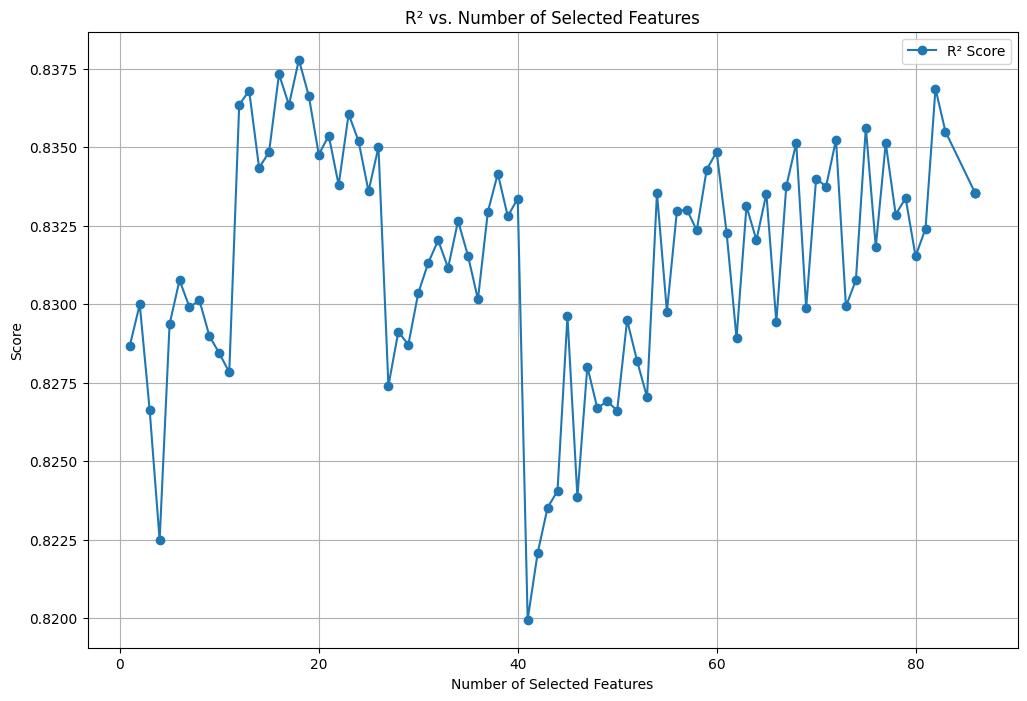

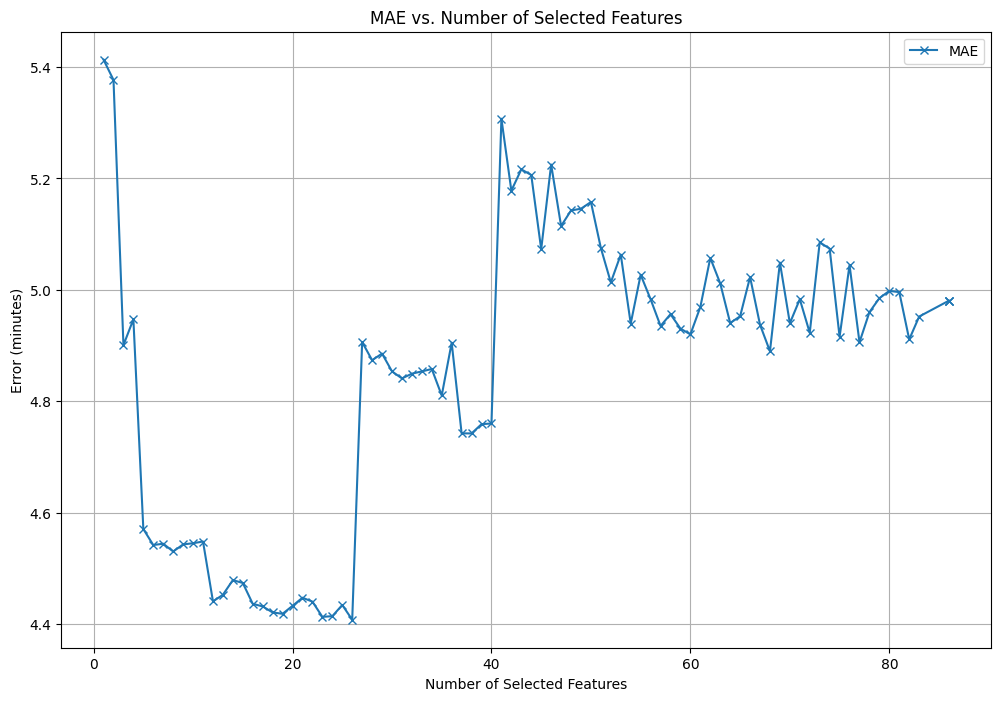

In [57]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(num_features, r2_scores, marker='o', label='R² Score')
# plt.plot(num_features, mae_scores, marker='x', label='MAE')
# plt.plot(num_features, mse_scores, marker='s', label='MSE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Score')
plt.title('R² vs. Number of Selected Features')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(num_features, mae_scores, marker='x', label='MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Error (minutes)')
plt.title('MAE vs. Number of Selected Features')
plt.legend()
plt.grid(True)
plt.show()

## Fine-tune the model using Feature Importance results

In [86]:
new_features = feature_importance.feature.values[:optimal_num_features - 1]

In [87]:
new_features

array(['route_hour_pattern_median_arrival_delay',
       'route_hour_pattern_median_departure_delay',
       'route_hour_pattern_rolling_arrival_delay',
       'route_hour_pattern_rolling_departure_delay',
       'route_station_avg_total_dep', 'route_station_median_total_dep',
       'route_station_avg_total_arr', 'precipitation_on_arrival',
       'route_station_std_total_dep', 'poor_visibility',
       'precipitation_on_departure',
       'route_station_ewm_7days_arrival_delay',
       'route_day_of_week_pattern_avg_departure_delay',
       'route_day_of_week_pattern_median_arrival_delay',
       'route_station_std_total_arr',
       'route_hour_pattern_std_arrival_delay',
       'route_station_max_total_arr'], dtype=object)

In [88]:
X_train = train_data[new_features]
y_train = train_data[["arrival_delay", "departure_delay"]]
X_test = test_data[new_features]
y_test = test_data[["arrival_delay", "departure_delay"]]

In [89]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [90]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 SINGLE STATION RESULTS:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f} minutes")

# Feature importance
feature_importance = pd.DataFrame(
    {"feature": new_features, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

print(f"\n🔍 TOP 20 FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(20).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<50} {row['importance']:.3f}")


📊 SINGLE STATION RESULTS:
MSE: 106.32
R²: 0.837
MAE: 4.42 minutes

🔍 TOP 20 FEATURES:
 1. route_hour_pattern_median_arrival_delay            0.401
 2. route_hour_pattern_median_departure_delay          0.273
 3. route_hour_pattern_rolling_departure_delay         0.036
 4. route_station_avg_total_dep                        0.032
 5. route_hour_pattern_rolling_arrival_delay           0.032
 6. route_station_avg_total_arr                        0.022
 7. route_station_ewm_7days_arrival_delay              0.022
 8. route_day_of_week_pattern_median_arrival_delay     0.022
 9. precipitation_on_arrival                           0.020
10. route_day_of_week_pattern_avg_departure_delay      0.020
11. route_station_std_total_arr                        0.020
12. route_station_max_total_arr                        0.020
13. route_station_median_total_dep                     0.020
14. route_station_std_total_dep                        0.020
15. route_hour_pattern_std_arrival_delay               0.01

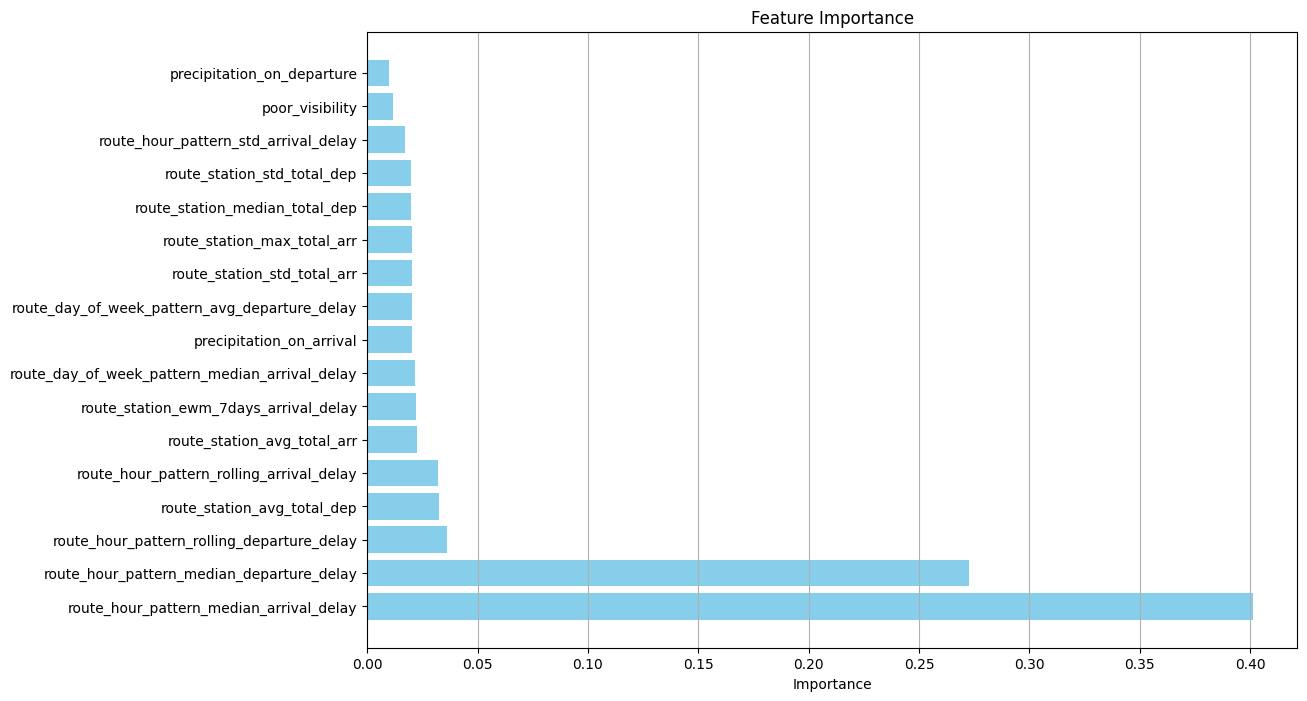

In [91]:
# plot top features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.show()

In [92]:
# test model training and inference speed
from time import perf_counter
for _ in range(10):
    start_time = perf_counter()
    model.fit(X_train, y_train)
    end_time = perf_counter()
    print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 4.4028 seconds
Training time: 4.3864 seconds
Training time: 4.3689 seconds
Training time: 4.2185 seconds
Training time: 4.2894 seconds
Training time: 4.6929 seconds
Training time: 5.2518 seconds
Training time: 4.2885 seconds
Training time: 4.1846 seconds
Training time: 4.1508 seconds


## Export the model and the feature importance results

In [116]:
# export the model and the feature importance results
joblib.dump(model, "../models/trip_xgboost_model_v1.0.joblib")
feature_importance.feature.to_csv("../models/trip_xgboost_feature_importance_v1.0.csv", index=False)